In [1]:
import findspark
#findspark.init()

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('GangaRiver').master('local[*]').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

22/11/25 17:38:33 WARN Utils: Your hostname, nikhil resolves to a loopback address: 127.0.1.1; using 192.168.68.127 instead (on interface usb0)
22/11/25 17:38:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/25 17:38:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('file:///media/nikhil/New Volume/Data Science/MachineLearning/Projects/GangaRiverPollutionClassification/ganga.csv', header = True, inferSchema = True)

# Print the schema of the dataset
df.printSchema()

root
 |-- DO: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- ORP: double (nullable = true)
 |-- Cond: double (nullable = true)
 |-- Temp: double (nullable = true)
 |-- WQI: double (nullable = true)
 |-- Status: string (nullable = true)



# Data Preprocessing 

In [4]:
# top 20 rows of the dataset
df.show()

# Number of rows in the dataset.
print (f'Number of rows in the dataset: ', df.count())

+-----------+----------+----------+-----------+---------+-----------+---------+
|         DO|        pH|       ORP|       Cond|     Temp|        WQI|   Status|
+-----------+----------+----------+-----------+---------+-----------+---------+
| 8.63052641|  8.879727|0.08482218| 0.04469828|22.650238|20.50452959|     Fair|
|8.644232787|  8.866815|0.08629203|0.044651296|22.567017|20.35919708|     Fair|
|  13.501176| 12.359906|0.14290023|   46.19519|18.400787|42.01432799|Very Poor|
|9.458531041| 12.825684|0.14623594|   52.60968|18.013641|47.74543444|Very Poor|
|  12.409351| 12.998978|0.14672422|  52.399826| 18.18457|46.92559347|Very Poor|
|  13.330035| 13.105331|0.14353323|  41.708813|18.367126|47.72259341|Very Poor|
|  10.858296|13.1836815|0.14233637|   52.92656|18.268341|48.31563432|Very Poor|
|   11.62481| 13.263382|0.14168048|   53.68222|18.302948|48.92207343|Very Poor|
|  13.488875| 13.269672|0.14186788|  53.700462|18.293518|48.97121512|Very Poor|
|   15.40315| 13.209754|0.14616036|  53.

In [5]:
# Count the number of None, null, empty string present in the dataset.
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

print ("0 null values present in the dataset")

+---+---+---+----+----+---+------+
| DO| pH|ORP|Cond|Temp|WQI|Status|
+---+---+---+----+----+---+------+
|  0|  0|  0|   0|   0|  0|     0|
+---+---+---+----+----+---+------+

0 null values present in the dataset


In [6]:
# Summary of numeric features

numeric_features = [t[0] for t in df.dtypes if t[1] == 'double']
df.select(numeric_features).describe().toPandas()

,summary,DO,pH,ORP,Cond,Temp,WQI
0,count,102,102,102,102,102,102
1,mean,9.05368230788235,11.687089581862747,0.11784825842156867,74.92706724682351,24.94930492156863,42.85132681362745
2,stddev,2.1438677413823193,1.7196198865988563,0.027042619803426524,134.46591741660794,5.365033911474017,11.327184823695244
3,min,7.465528178,8.49603,0.02918291,0.044651296,17.687866,14.1490993
4,max,15.40315,13.971594,0.15215278,394.34155,30.691772,63.32105591


In [7]:
# Print all classes for target column
df.select('Status').distinct().show()
classes_count = df.select('Status').distinct().count()
print ("There are ", classes_count, " classes in target column")

+---------+
|   Status|
+---------+
|     Good|
|     Fair|
|Very Poor|
|     Poor|
+---------+

There are  4  classes in target column


In [8]:
# Counting the classes distribution
df.groupBy('Status').count().show()

+---------+-----+
|   Status|count|
+---------+-----+
|     Good|    1|
|     Fair|    5|
|Very Poor|   55|
|     Poor|   41|
+---------+-----+



# Feature Extraction

## Correlations between independent variables.

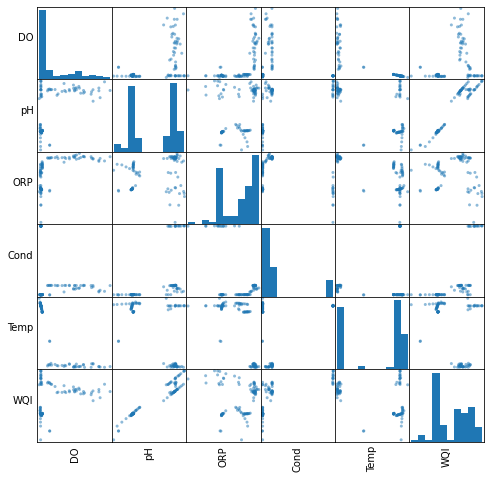

In [9]:
import pandas as pd

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From the above correlation matrix it can be seen that the WQI and pH have positive correlation and hence one of these feature can be removed.

## Machine Learning

## Preparing data for machine learning
The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [10]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
stages = []

indexer = StringIndexer(inputCol="Status", outputCol="label")
stages += [indexer]

assemblerInputs = numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [73]:
import random
import numpy as np
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
from pyspark.sql.types import ArrayType, FloatType


def smote(vectorized_sdf,smote_config, min_, maj_):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: cat cols are already stringindexed, num cols are assembled into 'features' vector
      df target col should be 'label'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    dataInput_min = vectorized_sdf[vectorized_sdf['label'] == min_]
    dataInput_maj = vectorized_sdf[vectorized_sdf['label'] == maj_]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",seed=smote_config.seed, bucketLength=smote_config.bucketLength)
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)
    
    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float("inf"), distCol="EuclideanDistance")
    
    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)
    
    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")
    
    self_similarity_df = self_join_w_distance.withColumn("r_num", F.row_number().over(over_original_rows))
    
    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= smote_config.k)

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = F.udf(lambda arr: random.uniform(0, 1)*(arr[0]-arr[1]), VectorUDT())
    add_vector_udf = F.udf(lambda arr: arr[0]+arr[1], VectorUDT())
    
    @udf(returnType=VectorUDT())
    def trimFeatures (arr):
        return Vectors.dense(arr.round(decimals=5))
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(smote_config.multiplier):
        print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected.withColumn("rand", F.rand()).withColumn('max_rand', F.max('rand').over(over_original_rows_no_order))\
                            .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
        
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel.select('*', subtract_vector_udf(F.array('datasetA.features', 'datasetB.features')).alias('vec_diff'))
        df_vec_modified = df_vec_diff.select('*', add_vector_udf(F.array('datasetA.features', 'vec_diff')).alias('features'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c,F.col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.unionAll, res)
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(vectorized_sdf.select(dfunion.columns))
    #oversampled_df_ = oversampled_df.withColumn('features_', trimFeatures('features'))
    oversampled_df_ = oversampled_df.select(col('label'), trimFeatures(col('features')).alias("features"))
    return oversampled_df_

In [13]:
df.groupBy('label').count().show()
df.select('features').show(1, 0)

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   55|
|  1.0|   41|
|  3.0|    1|
|  2.0|    5|
+-----+-----+

+-----------------------------------------------------------------+
|features                                                         |
+-----------------------------------------------------------------+
|[8.63052641,8.879727,0.08482218,0.04469828,22.650238,20.50452959]|
+-----------------------------------------------------------------+
only showing top 1 row



In [74]:
class smoteConfig:
    def __init__ (self, seed=127, bucketLength = 128, k=2, multiplier=3):
        self.seed = seed
        self.bucketLength = bucketLength
        self.k = k
        self.multiplier = multiplier
sC = smoteConfig()
df1 = smote (df, sC, 4.0, 0.0)
df1.printSchema()
df1.show(1, 0)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

+-----+--------------------------------------------------+
|label|features                                          |
+-----+--------------------------------------------------+
|2.0  |[8.63053,8.87973,0.08482,0.0447,22.65024,20.50453]|
+-----+--------------------------------------------------+
only showing top 1 row



In [75]:
df1.groupBy('label').count().show()
df1.select('features').show(1, 0)

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   55|
|  1.0|   41|
|  3.0|    1|
|  2.0|    5|
+-----+-----+

+--------------------------------------------------+
|features                                          |
+--------------------------------------------------+
|[8.63053,8.87973,0.08482,0.0447,22.65024,20.50453]|
+--------------------------------------------------+
only showing top 1 row



In [76]:
df2 = smote (df1, sC, 3.0, 0.0)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances


In [77]:
df3 = smote (df2, sC, 2.0, 0.0)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances


In [78]:
df = df3

In [81]:
df.count()

22/11/25 19:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/11/25 19:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB


117

We have now feature columns and label columns.

Now, data is splitted randomly into train and test sets, and set seed for reproducibility

In [82]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
#df.groupBy('label').count().show()

22/11/25 19:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/11/25 19:31:52 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB


22/11/25 19:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1247.6 KiB


Training Dataset Count: 84


22/11/25 19:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/11/25 19:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB


22/11/25 19:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1247.6 KiB
Test Dataset Count: 33


## Logistic Regression Classifier

In [83]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=0.0, elasticNetParam=0.8)
lrModel = lr.fit(train)

22/11/25 19:37:07 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


22/11/25 19:39:41 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


22/11/25 19:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1257.1 KiB
22/11/25 19:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1258.2 KiB


22/11/25 19:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB


22/11/25 19:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB


22/11/25 19:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
22/11/25 19:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB
22/11/25 19:41:39 WAR

22/11/25 19:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


In [84]:
predictions = lrModel.transform(test)
predictions.groupBy("prediction").count().show()

22/11/25 19:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/11/25 19:45:07 WARN DAGScheduler: Broadcasting large task binary with size 1217.6 KiB


22/11/25 19:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1276.3 KiB


+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|   14|
|       2.0|    3|
|       0.0|   16|
+----------+-----+



In [85]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("label")
evaluator.setPredictionCol ("prediction")
print("Test Area under ROC: ", evaluator.evaluate (predictions))

22/11/25 19:47:43 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


22/11/25 19:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1276.8 KiB
Test Area under ROC:  0.8993939393939394


In [86]:
from pyspark.mllib.evaluation import MulticlassMetrics
preds_and_labels = predictions.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

22/11/25 19:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


/home/nikhil/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


22/11/25 19:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1266.5 KiB


In [87]:
print(metrics.confusionMatrix())

22/11/25 19:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB


DenseMatrix([[16.,  0.,  0.],
             [ 0., 11.,  0.],
             [ 0.,  3.,  3.]])


In [88]:

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.9090909090909091
Weighted precision = 0.9285714285714286
Weighted F(1) Score = 0.8993939393939394
Weighted F(0.5) Score = 0.9099954771596562
Weighted false positive rate = 0.045454545454545456


## Decision Tree Classifier

In [89]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 8)
dtModel = dt.fit(train)

22/11/25 19:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:52:59 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


22/11/25 19:55:34 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 19:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


22/11/25 19:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1254.7 KiB
22/11/25 19:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1254.8 KiB


22/11/25 19:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1258.2 KiB
22/11/25 19:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
22/11/25 19:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1260.2 KiB
22/11/25 19:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1260.5 KiB
22/11/25 19:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1260.8 KiB
22/11/25 19:57:18 WARN DAGScheduler: Broadcasting large task binary with size 1261.3 KiB


In [90]:
predictions = dtModel.transform(test)
predictions.groupBy("prediction").count().show()

22/11/25 19:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/11/25 19:58:20 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB


22/11/25 19:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1277.0 KiB
+----------+-----+
|prediction|count|
+----------+-----+
|       2.0|    5|
|       1.0|   12|
|       0.0|   16|
+----------+-----+



In [91]:
evaluator.setLabelCol("label")
evaluator.setPredictionCol ("prediction")
print("Test Area under ROC: ", evaluator.evaluate (predictions))

22/11/25 20:00:57 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:00:58 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


22/11/25 20:02:36 WARN DAGScheduler: Broadcasting large task binary with size 1277.5 KiB
Test Area under ROC:  0.9689783207569769


In [92]:
preds_and_labels = predictions.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

22/11/25 20:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


22/11/25 20:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1266.6 KiB


In [93]:
print(metrics.confusionMatrix())

22/11/25 20:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1277.0 KiB
DenseMatrix([[16.,  0.,  0.],
             [ 0., 11.,  0.],
             [ 0.,  1.,  5.]])


In [94]:
# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.9696969696969697
Weighted precision = 0.9722222222222222
Weighted F(1) Score = 0.9689783207569769
Weighted F(0.5) Score = 0.9704081229504957
Weighted false positive rate = 0.015151515151515152


## Random Forest Classifier

In [95]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

22/11/25 20:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


22/11/25 20:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


22/11/25 20:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1254.7 KiB
22/11/25 20:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1254.8 KiB


22/11/25 20:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1258.2 KiB
22/11/25 20:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1261.1 KiB
22/11/25 20:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1267.8 KiB
22/11/25 20:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1272.4 KiB
22/11/25 20:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1272.8 KiB
22/11/25 20:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1267.1 KiB


22/11/25 20:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


In [96]:
predictions = rfModel.transform(test)
predictions.groupBy("prediction").count().show()

22/11/25 20:14:39 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/11/25 20:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1217.6 KiB


22/11/25 20:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
+----------+-----+
|prediction|count|
+----------+-----+
|       2.0|    5|
|       1.0|   12|
|       0.0|   16|
+----------+-----+



In [97]:
evaluator.setLabelCol("label")
evaluator.setPredictionCol ("prediction")
print("Test Area under ROC: ", evaluator.evaluate (predictions))

22/11/25 20:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


22/11/25 20:19:13 WARN DAGScheduler: Broadcasting large task binary with size 1333.7 KiB
Test Area under ROC:  0.9689783207569769


In [98]:
preds_and_labels = predictions.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

22/11/25 20:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB


22/11/25 20:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB


22/11/25 20:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1323.1 KiB


In [99]:
print(metrics.confusionMatrix())

22/11/25 20:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
DenseMatrix([[16.,  0.,  0.],
             [ 0., 11.,  0.],
             [ 0.,  2.,  4.]])


In [100]:
# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.9393939393939394
Weighted precision = 0.9487179487179487
Weighted F(1) Score = 0.9358585858585858
Weighted F(0.5) Score = 0.941143032052123
Weighted false positive rate = 0.030303030303030304
